In [1]:
from PIL import Image
import os, glob
import numpy as np
from dataset.mnist import load_mnist
root_dir = "./figures/"
categories = ["circle","square", "star", "triangle"]

In [2]:
image_width = 28
image_height = 28

X=[] #훈련 X
T=[] #훈련 T

for idx, category in enumerate(categories):
    image_dir = root_dir + category
    #3000개의 이미지 불러오기
    for j in range(3000):
        str_j = str(j)
        img = Image.open(image_dir + '/'+str_j +'.png')
        img = img.resize((image_width, image_height))
        data = np.asarray(img)
        X.append(data)
        T.append(idx)

In [3]:
X = np.array(X)
T = np.array(T)# 넘파이 배열로
X = X.reshape(12000, 784) #flatten
X = X/X.max()# normalized

In [4]:
(first_train_x, first_train_t), (first_test_x, first_test_t) = \
load_mnist(normalize=True, flatten=True, one_hot_label=False) #mnist 데이터

In [5]:
Train_X = np.vstack([first_train_x, X])
T = T +10 #index를 mnist데이터와 구분하기 위해 
Train_T = np.hstack([first_train_t, T])

In [6]:
class SGD:

    """확률적 경사 하강법（Stochastic Gradient Descent）"""

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key] 


class Momentum:

    """모멘텀 SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]
            
class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


In [7]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx

In [8]:
class BatchNormalization:
    """
    http://arxiv.org/abs/1502.03167
    """
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # 합성곱 계층은 4차원, 완전연결 계층은 2차원  

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.input_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta 
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma
        self.dbeta = dbeta
        
        return dx
    


In [9]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

def sigmoid(x):
    return 1 / (1 + np.exp(-x)) 
def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx
    
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx
    

In [10]:
#테스트 데이터 불러오기 
X_test = []
T_test = []
for idx, category in enumerate(categories):
    image_dir = root_dir + category
    #나머지의 이미지 불러오기
    for j in range(700):
        str_j = str(j+3000)
        img = Image.open(image_dir + '/'+str_j +'.png')
        img = img.resize((image_width, image_height))
        data = np.asarray(img)
        X_test.append(data)
        T_test.append(idx)
        
X_test = np.array(X_test)
T_test = np.array(T_test) #넘파이 배열로

In [11]:
X_test = X_test.reshape(X_test.shape[0], 784)
X_test = X_test/ X_test.max()

T_test = T_test + 10

Test_X = np.vstack([X_test, first_test_x])
Test_T = np.hstack([T_test, first_test_t]) #테스트 데이터 하나로 합치기 (최종 테스트 데이터)

In [12]:
#원핫인코딩
Train_T_onehot = np.zeros((Train_T.size, Train_T.max()+1))
Train_T_onehot[np.arange(Train_T.size), Train_T ] = 1
Test_T_onehot = np.zeros((Test_T.size, Test_T.max()+1))
Test_T_onehot[np.arange(Test_T.size), Test_T ] = 1

In [13]:
from collections import OrderedDict

In [14]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, use_batchNorm = False):
        # 가중치 He 사용
        self.use_batchNorm = use_batchNorm
        weight_init_std1 = 2/np.sqrt(input_size)
        weight_init_std2 = 2/np.sqrt(hidden_size)
        self.params = {}
        self.params['W1'] = weight_init_std1 * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std2 * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        if self.use_batchNorm :
            self.params['gamma'] = np.ones(hidden_size)
            self.params['beta'] = np.zeros(hidden_size)
            self.layers['BatchNorm'] = BatchNormalization(self.params['gamma'], self.params['beta'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        
        if self.use_batchNorm :
            grads['gamma'] = self.layers['BatchNorm'].dgamma
            grads['beta' ] = self.layers['BatchNorm'].dbeta

        return grads


optimizer를 SGD, AdaGrad, Momentum 중에 입력하시오 : Momentum
train acc, test acc | 0.05304166666666667, 0.048984375
train acc, test acc | 0.935125, 0.938046875
train acc, test acc | 0.9482777777777778, 0.94984375
train acc, test acc | 0.9558194444444444, 0.955390625
train acc, test acc | 0.9608472222222222, 0.95984375
train acc, test acc | 0.9663611111111111, 0.963671875
train acc, test acc | 0.9681388888888889, 0.964296875
train acc, test acc | 0.9716527777777778, 0.96734375
train acc, test acc | 0.9735972222222222, 0.967890625
train acc, test acc | 0.9755555555555555, 0.970625
train acc, test acc | 0.9765972222222222, 0.9721875
train acc, test acc | 0.9784027777777777, 0.973359375
train acc, test acc | 0.9782083333333333, 0.972265625
train acc, test acc | 0.9805833333333334, 0.975078125


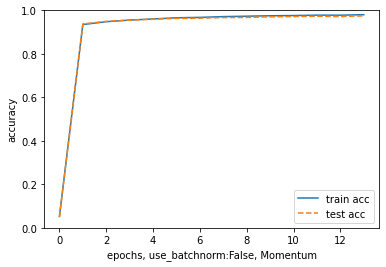

accuracy:0.975078125


In [77]:

import sys, os
import numpy as np
import matplotlib.pyplot as plt


    
#훈련 데이터 설정
x_train, t_train = Train_X, Train_T_onehot

#테스트 데이터 설정
testx = Test_X
testt = Test_T_onehot

# 하이퍼파라미터
iters_num = 10000 
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

#momentum, false로 구현
#optimizer
opti = input('optimizer를 SGD, AdaGrad, Momentum 중에 입력하시오 : ')
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=14, use_batchNorm = False) #배치 정규화 선택할 수 있도록
#use_batchNorm이 True면 배치 정규화 사용, False이면 미사용


if opti == 'SGD':
    optimizer = SGD()
if opti =='AdaGrad':
    optimizer = AdaGrad()
if opti =='Momentum':
    optimizer = Momentum()
train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    grad = network.gradient(x_batch, t_batch)
    params = network.params
    # 매개변수 갱신
    optimizer.update(params, grad)
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(testx, testt)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

        
# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs, "+"use_batchnorm:"+str(network.use_batchNorm)+', '+opti)
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

print('accuracy:'+str(test_acc_list[-1]))


optimizer를 SGD, AdaGrad, Momentum 중에 입력하시오 : AdaGrad
train acc, test acc | 0.1415, 0.150546875
train acc, test acc | 0.9366111111111111, 0.936953125
train acc, test acc | 0.9428472222222222, 0.94203125
train acc, test acc | 0.9517083333333334, 0.950234375
train acc, test acc | 0.9552361111111111, 0.95375
train acc, test acc | 0.95825, 0.956015625
train acc, test acc | 0.9605, 0.958203125
train acc, test acc | 0.9621111111111111, 0.95875
train acc, test acc | 0.9630972222222223, 0.959296875
train acc, test acc | 0.9642361111111111, 0.960078125
train acc, test acc | 0.9654444444444444, 0.962109375
train acc, test acc | 0.9660416666666667, 0.962421875
train acc, test acc | 0.9665972222222222, 0.963046875
train acc, test acc | 0.9679444444444445, 0.963046875


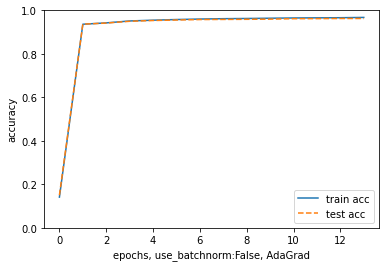

accuracy:0.963046875


In [78]:
#Adagrad, false로 구현
#optimizer -
opti = input('optimizer를 SGD, AdaGrad, Momentum 중에 입력하시오 : ')
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=14, use_batchNorm = False) #배치 정규화 선택할 수 있도록
#use_batchNorm이 True면 배치 정규화 사용, False이면 미사용


if opti == 'SGD':
    optimizer = SGD()
if opti =='AdaGrad':
    optimizer = AdaGrad()
if opti =='Momentum':
    optimizer = Momentum()
train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    grad = network.gradient(x_batch, t_batch)
    params = network.params
    # 매개변수 갱신
    optimizer.update(params, grad)
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(testx, testt)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

        
# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs, "+"use_batchnorm:"+str(network.use_batchNorm)+', '+opti)
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

print('accuracy:'+str(test_acc_list[-1]))


optimizer를 SGD, AdaGrad, Momentum 중에 입력하시오 : SGD
train acc, test acc | 0.07786111111111112, 0.072890625
train acc, test acc | 0.8597777777777778, 0.86640625
train acc, test acc | 0.8929583333333333, 0.897734375
train acc, test acc | 0.9084583333333334, 0.91625
train acc, test acc | 0.9169166666666667, 0.924765625
train acc, test acc | 0.9219861111111111, 0.929453125
train acc, test acc | 0.9255416666666667, 0.9325
train acc, test acc | 0.9282361111111112, 0.9340625
train acc, test acc | 0.9319722222222222, 0.93734375
train acc, test acc | 0.9350416666666667, 0.93953125
train acc, test acc | 0.9367361111111111, 0.941328125
train acc, test acc | 0.9382222222222222, 0.9421875
train acc, test acc | 0.9404027777777778, 0.942890625
train acc, test acc | 0.9420138888888889, 0.94375


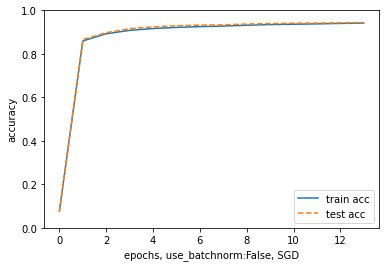

accuracy:0.94375


In [79]:
#SGD, false로 구현
#optimizer -
opti = input('optimizer를 SGD, AdaGrad, Momentum 중에 입력하시오 : ')
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=14, use_batchNorm = False) #배치 정규화 선택할 수 있도록
#use_batchNorm이 True면 배치 정규화 사용, False이면 미사용


if opti == 'SGD':
    optimizer = SGD()
if opti =='AdaGrad':
    optimizer = AdaGrad()
if opti =='Momentum':
    optimizer = Momentum()
train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    grad = network.gradient(x_batch, t_batch)
    params = network.params
    # 매개변수 갱신
    optimizer.update(params, grad)
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(testx, testt)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

        
# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs, "+"use_batchnorm:"+str(network.use_batchNorm)+', '+opti)
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()
print('accuracy:'+str(test_acc_list[-1]))


optimizer를 SGD, AdaGrad, Momentum 중에 입력하시오 : SGD
train acc, test acc | 0.10123611111111111, 0.096640625
train acc, test acc | 0.878125, 0.8809375
train acc, test acc | 0.9085277777777778, 0.915703125
train acc, test acc | 0.9207083333333334, 0.9265625
train acc, test acc | 0.9288194444444444, 0.933203125
train acc, test acc | 0.9344722222222223, 0.938984375
train acc, test acc | 0.9384027777777778, 0.942109375
train acc, test acc | 0.9417777777777778, 0.943359375
train acc, test acc | 0.9446805555555555, 0.945078125
train acc, test acc | 0.947375, 0.9475
train acc, test acc | 0.9493611111111111, 0.94984375
train acc, test acc | 0.9514861111111111, 0.95078125
train acc, test acc | 0.9533611111111111, 0.95109375
train acc, test acc | 0.9549027777777778, 0.952578125


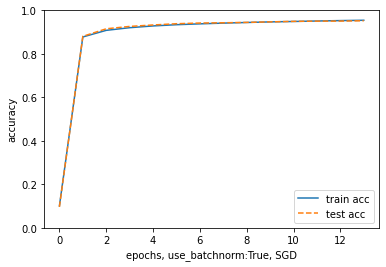

accuracy:0.952578125


In [80]:
#SGD, true로 구현
#optimizer -
opti = input('optimizer를 SGD, AdaGrad, Momentum 중에 입력하시오 : ')
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=14, use_batchNorm = True) #배치 정규화 선택할 수 있도록
#use_batchNorm이 True면 배치 정규화 사용, False이면 미사용


if opti == 'SGD':
    optimizer = SGD()
if opti =='AdaGrad':
    optimizer = AdaGrad()
if opti =='Momentum':
    optimizer = Momentum()
train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    grad = network.gradient(x_batch, t_batch)
    params = network.params
    # 매개변수 갱신
    optimizer.update(params, grad)
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(testx, testt)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

        
# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs, "+"use_batchnorm:"+str(network.use_batchNorm)+', '+opti)
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()
print('accuracy:'+str(test_acc_list[-1]))


optimizer를 SGD, AdaGrad, Momentum 중에 입력하시오 : AdaGrad
train acc, test acc | 0.23105555555555554, 0.21125
train acc, test acc | 0.9438194444444444, 0.94515625
train acc, test acc | 0.9545, 0.95203125
train acc, test acc | 0.9594583333333333, 0.957265625
train acc, test acc | 0.9627638888888889, 0.960625
train acc, test acc | 0.96575, 0.96265625
train acc, test acc | 0.96825, 0.962421875
train acc, test acc | 0.9697916666666667, 0.963359375
train acc, test acc | 0.9713611111111111, 0.964375
train acc, test acc | 0.9725, 0.966484375
train acc, test acc | 0.9735416666666666, 0.967578125
train acc, test acc | 0.9745694444444445, 0.967890625
train acc, test acc | 0.9756527777777778, 0.968125
train acc, test acc | 0.9766388888888888, 0.969609375


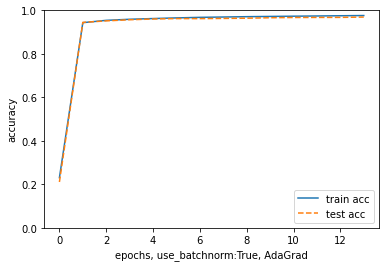

accuracy:0.969609375


In [81]:
#Adagrad, True로 구현
#optimizer -
opti = input('optimizer를 SGD, AdaGrad, Momentum 중에 입력하시오 : ')
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=14, use_batchNorm = True) #배치 정규화 선택할 수 있도록
#use_batchNorm이 True면 배치 정규화 사용, False이면 미사용


if opti == 'SGD':
    optimizer = SGD()
if opti =='AdaGrad':
    optimizer = AdaGrad()
if opti =='Momentum':
    optimizer = Momentum()
train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    grad = network.gradient(x_batch, t_batch)
    params = network.params
    # 매개변수 갱신
    optimizer.update(params, grad)
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(testx, testt)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

        
# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs, "+"use_batchnorm:"+str(network.use_batchNorm)+', '+opti)
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()
print('accuracy:'+str(test_acc_list[-1]))


optimizer를 SGD, AdaGrad, Momentum 중에 입력하시오 : Momentum
train acc, test acc | 0.08158333333333333, 0.0784375
train acc, test acc | 0.9392361111111112, 0.93828125
train acc, test acc | 0.9557777777777777, 0.953515625
train acc, test acc | 0.9636527777777778, 0.959765625
train acc, test acc | 0.9686527777777778, 0.963671875
train acc, test acc | 0.9722361111111111, 0.966796875
train acc, test acc | 0.9756944444444444, 0.96921875
train acc, test acc | 0.9769722222222222, 0.970390625
train acc, test acc | 0.9790277777777778, 0.97203125
train acc, test acc | 0.9796527777777778, 0.971640625
train acc, test acc | 0.9822777777777778, 0.972109375
train acc, test acc | 0.9826388888888888, 0.9740625
train acc, test acc | 0.9836388888888888, 0.97421875
train acc, test acc | 0.984875, 0.9746875


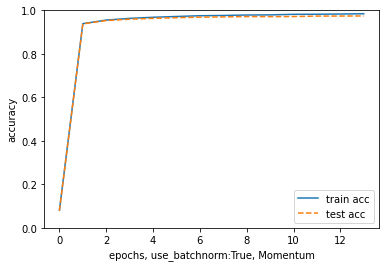

accuracy:0.9746875


In [82]:
#Momentum, True로 구현
#optimizer -
opti = input('optimizer를 SGD, AdaGrad, Momentum 중에 입력하시오 : ')
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=14, use_batchNorm = True) #배치 정규화 선택할 수 있도록
#use_batchNorm이 True면 배치 정규화 사용, False이면 미사용


if opti == 'SGD':
    optimizer = SGD()
if opti =='AdaGrad':
    optimizer = AdaGrad()
if opti =='Momentum':
    optimizer = Momentum()
train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    grad = network.gradient(x_batch, t_batch)
    params = network.params
    # 매개변수 갱신
    optimizer.update(params, grad)
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(testx, testt)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

        
# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs, "+"use_batchnorm:"+str(network.use_batchNorm)+', '+opti)
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()
print('accuracy:'+str(test_acc_list[-1]))
